Used for experimental analysis and plotting

In [1]:
from loaders import gvsoc_loader, rtl_loader

import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import argparse
import logging
import json5
import os
from pathlib import Path
import pandas as pd

pio.kaleido.scope.mathjax=None # Disable mathjax to avoid weird bug when saving as pdf

PATTERN='NO_LOAD_SINGLE'

DMCPYI_TO_MCYCLE = False # ENable to use the DMCPYI instruction as the first border, instead of the first mcycle. Not recommend and probably broken


CLOCK_FREQ = 1_000_000_000 # [Hz]
MAX_BW = 64*CLOCK_FREQ / 1_000_000_000 # [GB/s]

# GVSOC_TRACE_FILE = '/scratch/sem24h19/logs/gvsoc/logs_insn.ansi'
# RTL_PERF_FOLDER = '../flooccamy/logs'

RTL_LOGS_DIR = Path('/scratch2/sem24h19/measurements/rtl')
GVSOC_LOGS_DIR = Path('/scratch2/sem24h19/measurements/gvsoc')


In [56]:
file = "results_full_load.csv"

data = pd.read_csv(file)
data.sort_values(by=['payload_size'], inplace=True)
fig = px.line(data, x="payload_size", y=data.columns, markers=True)
fig.show()

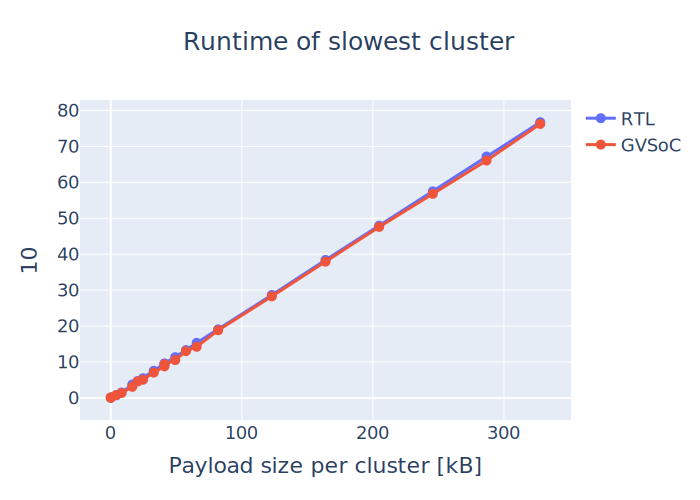

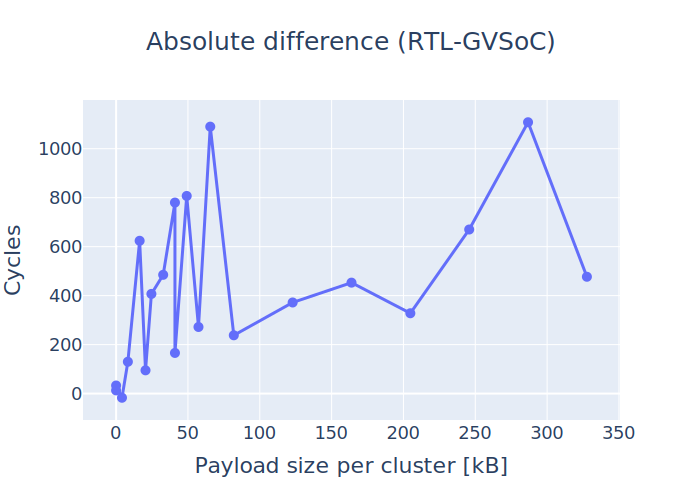

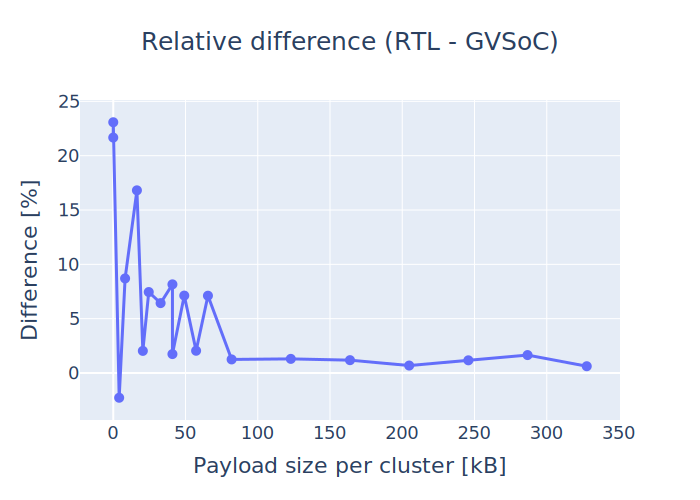

In [23]:
file = "results_full_load.csv"
data = pd.read_csv(file)
data.sort_values(by=['payload_size'], inplace=True)
rtl_color = "rgb(0, 0, 255)"
gvsoc_color = "rgb(255, 0, 0)"

fig1 = go.Figure()
fig2 = go.Figure()
fig3 = go.Figure()
# fig.add_trace(go.Scatter(x=data["payload_size"], y=data["average_system_latency_gvsoc"], error_y=dict(
#             type='data', # value of error bar given in data coordinates
#             array=data["std_system_latency_gvsoc"],
#             visible=True), 
#             line=dict(color=gvsoc_color)))
# fig.add_trace(go.Scatter(x=data["payload_size"], y=data["average_system_latency_rtl"], error_y=dict(
#             type='data', # value of error bar given in data coordinates
#             array=data["std_system_latency_rtl"],
#             visible=True),
#             line=dict(color=rtl_color)))
diff = data["maximum_system_latency_rtl"]-data["maximum_system_latency_gvsoc"]

x_axis_title = "Payload size per cluster [kB]"
marker_size = 10

fig1.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=data["maximum_system_latency_rtl"]/1000.0,name="RTL", mode="lines+markers", line=dict(width=3), marker=dict(size=marker_size)))
fig1.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=data["maximum_system_latency_gvsoc"]/1000.0,name="GVSoC", mode="lines+markers", line=dict(width=3), marker=dict(size=marker_size)))
fig1.update_layout(yaxis_title="10<sup>3</sup> Cycles", xaxis_title=x_axis_title, title=dict(text="Runtime of slowest cluster", x=0.5), font=dict(size=18))

fig2.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=diff, mode="lines+markers", line=dict(width=3), marker=dict(size=marker_size)))
fig2.update_layout(font=dict(size=18), yaxis_title="Cycles",xaxis_title=x_axis_title, title=dict(text="Absolute difference (RTL-GVSoC)", x=0.5))

fig3.update_layout(font=dict(size=18), xaxis_title=x_axis_title, title=dict(text="Relative difference (RTL - GVSoC)", x=0.5))
fig3.update_yaxes(title_text="Difference [%]")
fig3.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=100*diff/data["maximum_system_latency_rtl"],yaxis="y", mode="lines+markers", line=dict(width=3), marker=dict(size=marker_size)))
# fig.add_trace(go.Scatter(x=data["payload_size"], y=data["minimum_system_latency_rtl"], mode="markers", marker=dict(color=rtl_color)))
# fig.add_trace(go.Scatter(x=data["payload_size"], y=data["minimum_system_latency_gvsoc"], mode="markers", marker=dict(color=gvsoc_color)))






fig1.show(renderer="svg")
fig1.write_image("total_latency_full_load.pdf")
fig2.show(renderer="svg")
fig2.write_image("absolute_diff_full_load.pdf")
fig3.show(renderer="svg")
fig3.write_image("relative_diff_full_load.pdf")



## Simulation Time

In [54]:
file = "results_full_load.csv"
data = pd.read_csv(file)
data.sort_values(by=['payload_size'], inplace=True)


speed_up = data["sim_time_rtl"] / data["sim_time_gvsoc"]

x_axis_title = "Payload size per cluster [kB]"
marker_size = 10


tickvals = np.concatenate((np.arange(1, 10, 1),
                           np.arange(10, 100, 10),
                           np.arange(100, 1000, 100),
                           np.arange(1000, 10001, 1000)))
ticktext = [f"{val}" if val in [10, 100, 1000, 10000] else '' for val in tickvals]

for i in range(len(tickvals)):
    if ticktext[i] == "100":
        ticktext[i] = "10<sup>2</sup>"
    if ticktext[i] == "1000":
        ticktext[i] = "10<sup>3</sup>"
    if ticktext[i] == "10000":
        ticktext[i] = "10<sup>4</sup>"
    


fig = go.Figure()

fig.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=data["sim_time_rtl"], mode="lines+markers", name="RTL", line=dict(width=3), marker=dict(size=marker_size)))
fig.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=data["sim_time_gvsoc"], mode="lines+markers", name="GVSoC", line=dict(width=3), marker=dict(size=marker_size)))
fig.update_yaxes(type="log", exponentformat="power", showgrid=True, tickvals=tickvals, ticktext=ticktext)
fig.update_layout(yaxis_title="Simulation time [s]", xaxis_title=x_axis_title, title=dict(text="Simulation time for RTL and GVSoC, Pattern: Full Load", x= 0.5),
                  font=dict(size=18),)
fig.show()
fig.write_image("sim_time.pdf")

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=data["payload_size"]/1000.0, y=speed_up, mode="lines+markers", name="Speedup", line=dict(width=3), marker=dict(size=marker_size)))
# fig2.update_yaxes(range=[0, 250])
fig2.update_layout(yaxis_title="Speedup factor", xaxis_title=x_axis_title, title=dict(text="Simulation time speedup, Pattern: Full Load", x= 0.5),
                   font=dict(size=18))
fig2.show()
fig2.write_image("speedup.pdf")


In [58]:
import numpy as np
import plotly.graph_objects as go

# Example data
data1 = np.random.rand(10, 10)
data2 = np.random.rand(10, 10)
difference = data1 - data2

# Calculate symmetric range for the colorscale
max_abs_diff = np.max(np.abs(difference))

# Create the heatmaps
fig = go.Figure()

fig.add_trace(go.Heatmap(
    z=data1,
    colorscale='Viridis',
    name='Data 1'
))

fig.add_trace(go.Heatmap(
    z=data2,
    colorscale='Viridis',
    name='Data 2'
))

fig.add_trace(go.Heatmap(
    z=difference,
    colorscale='RdBu',  # Diverging colorscale for negative and positive
    zmin=-max_abs_diff, # Symmetric range
    zmax=max_abs_diff,
    name='Difference',
    colorbar=dict(
        tickvals=[0, max_abs_diff],         # Only show ticks for positive values
        ticktext=["0", f"{max_abs_diff:.2f}"],  # Custom labels for the ticks
        title="Difference"
    )
))

# Update layout
fig.update_layout(
    title="Heatmaps with Hidden Negative Colorscale",
)

fig.show()
